In [104]:
import pandas as pd
import bamboolib
import os
import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from IPython.core.display import display, HTML
import re

## Analyse des segments

In [3]:
aymeric =  "/home/aymeric/python-scripts/anses_medialab/datas/" #aymeric
jp = 'd:/Projects/Medialab/Anses/' # Jean Philippe


path_base = aymeric
file_segmentation = f"{path_base}segmentation_common_freq.csv"

index=f"{path_base}index_alldefault_nameexhaustive_aymeric.csv"

all_corpus = f"{path_base}all_corpus_seg_with_sdhi_PI.csv"

#twittos = f"{path_base}tweets_pesticides/500_first_twittos_on_pesticides.csv"

data_file = path_base+'fb_tw_med_data.csv.gz'#,line_terminator='\n',index=False)


In [4]:
list_base = ["index", "all_corpus"]
which_base = list_base[0]

In [5]:
if which_base == "all_corpus":
    df0 = pd.read_csv(all_corpus, sep = "\t")
else:
    df_index = pd.read_csv(index, sep = "\t")
    dfseg0 = pd.read_csv(file_segmentation, sep = "\t")

    df_index['date'] = pd.to_datetime(df_index['date'], infer_datetime_format=True)
    df_index['yearmonth']=(df_index['date'].dt.strftime('%Y-%m'))
    df_index['date'] = df_index['date'].dt.date
    
    segment = dfseg[["yearmonth", "segm", "origin"]]
    df0 = df_index.merge(segment, how = "inner", on = ["origin", "yearmonth"])
    df0["start_segment"] = df0.groupby(['origin','segm'])["date"].transform('min')
    df0["end_segment"] = df0.groupby(['origin','segm'])["date"].transform('max')

In [6]:
dft = pd.read_csv(data_file)

In [7]:
# Step: Rename column
segment = df0[["yearmonth", "segm", "origin"]]
dft = dft.rename(columns={'id': 'doc_id'})

dft['date'] = pd.to_datetime(dft['date'], infer_datetime_format=True)

dft['yearmonth']=(dft['date'].dt.strftime('%Y-%m'))
dft['date'] = dft['date'].dt.date
    
segment = dfseg[["yearmonth", "segm", "origin"]]
dft0 = dft.merge(segment, how = "inner", on = ["origin", "yearmonth"])
dft0["start_segment"] = dft0.groupby(['origin','segm'])["date"].transform('min')
dft0["end_segment"] = dft0.groupby(['origin','segm'])["date"].transform('max')



## Facebook

In [8]:
dfseg0 = dfseg.copy()

In [178]:
def filter_data(data, domain, segment):
    print(domain)
    dfseg = data[0]
    dfseg1 = dfseg.loc[(dfseg["origin"] == domain) & (dfseg["segm"] == segment)]
    
    df = data[1]
    df1 = df.loc[(df["origin"] == domain) & (df["segm"] == segment)]
    
    dft = data[2]
    dft1 = dft.loc[(dft["origin"] == domain) & (dft["segm"] == segment)]
    dft1['doc_id'] = dft1['doc_id'].astype('string')
    
    specific_terms = [x.strip() for x in dfseg1["top20_term_chi2_True"].iloc[0].split(",")]

    print(specific_terms)

    df1.loc[df1["term"].isin(specific_terms) == True, "in_top20_term"] = 1
    df1.loc[df1["term"].isin(specific_terms) == False, "in_top20_term"] = 0
    df2 = df1.drop_duplicates(subset = ["doc_id", "term"]).groupby(['doc_id', 'source', "date"]).agg(sum_of_top20_term =('in_top20_term', 'sum')).reset_index()

    df2 = df2.merge(dft1[["doc_id", "text"]], how = "inner", on = ["doc_id"])
    
    return dfseg1, df1, dft1, df2, specific_terms

In [197]:
domains = ["facebook", "twitter", "media"]
segment = 7
domain = domains[1]

list_df = [dfseg0, df0, dft0]
dfseg1, df1, dft1, df2, specific_terms = filter_data(list_df, domain = domain, segment = segment)

twitter


IndexError: single positional indexer is out-of-bounds

In [180]:
moyenne = np.mean(df2["sum_of_top20_term"]) 
df3 = df2.loc[df2["sum_of_top20_term"] >= 2 ]
df3 = df3.sort_values(by=['date'], ascending=[True])

df3 = df3.drop_duplicates(subset = "text")

In [181]:
nombre_texts = len(df3["text"])
start_segment = df1["start_segment"].iloc[1].strftime("%Y-%m-%d")
end_segment = df1["end_segment"].iloc[1].strftime("%Y-%m-%d")

for i, text in enumerate(df3["text"]):
    doc_id = df3["doc_id"].iloc[i]
    list_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id)].unique()]
    list_top20_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id) & (df1["in_top20_term"] == 1)].unique()]
    list_top20_term_absent = set(specific_terms) - set(list_top20_term)
    date = df3["date"].iloc[i].strftime("%Y-%m-%d")
    auteur = df3["source"].iloc[i]
    display(HTML(f"<h2 style='text-align:center;'> Texte {doc_id} ({i+1} sur {nombre_texts})</h2>"))
    display(HTML(f"<strong>Segment :</strong> {segment} ({start_segment} ; {end_segment})"))
    display(HTML(f"<strong>Date :</strong> {date}"))
    display(HTML(f"<strong>Auteur :</strong> {auteur} \n"))
    print(f"Termes index√©s : {list_term} \n")
    print(f"Termes sp√©cifiques pr√©sents : {list_top20_term} \n")
    print(f"Termes sp√©cifiques absents : {list_top20_term_absent} \n")
    try:
        for j, term in enumerate(list_term):
            if term not in list_top20_term:
                text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)  
            else:
                text = re.sub(term, f'<mark style="background-color:pink">{term}</mark>', text, flags=re.I)  
        display(HTML(f'{text}'))
    except:
        print(f"{text} \n")
   

Termes index√©s : ['vins', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'plainte'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['ogm', 'roundup', 'malformations', 'd√©sherbant', 'glyphosate'] 

Termes sp√©cifiques pr√©sents : ['malformations', 'd√©sherbant'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['ogm', 'roundup', 'malformations', 'd√©sherbant', 'glyphosate'] 

Termes sp√©cifiques pr√©sents : ['malformations', 'd√©sherbant'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['malformations', 'd√©sherbant', 'glyphosate', 'mol√©cules', 'roundup', 'roundup de monsanto', 'monsanto'] 

Termes sp√©cifiques pr√©sents : ['malformations', 'd√©sherbant'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©sherbant', 'malformations'] 

Termes sp√©cifiques pr√©sents : ['d√©sherbant', 'malformations'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'frelon', 'ogm', 'apiculteur'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'frelon'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'frelon', 'apiculteur', 'unaf'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'frelon'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'frelon', 'ogm', 'apiculteur'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'frelon'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['abeilles', 'frelon', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['frelon', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'frelon', 'ogm', 'apiculteur'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'frelon'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'monsanto', 'cassation'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'cassation'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'bisph√©nol', 'bisph√©nol a', 'd√©bat'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'bisph√©nol', 'bisph√©nol a'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'nature environnement'} 



Termes index√©s : ['malformations', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['malformations', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'vitamines'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', '√©tudes'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 

http://bit.ly/aR8MysDes <mark style="background-color:yellow">r√©sidus</mark> de <mark style="background-color:pink">pesticides</mark> dans huit fruits sur dix 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'limite', 'limites maximales'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['avis', 'campagne', 'pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'c√©r√©aliers', 'c√©r√©alier charentais'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'c√©r√©alier charentais'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['paul fran√ßois', 'victimes', 'victimes de pesticides', 'pesticides', 'c√©r√©aliers', 'c√©r√©alier charentais'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'c√©r√©alier charentais'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'c√©r√©aliers', 'c√©r√©alier charentais', 'monsanto'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'c√©r√©alier charentais'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'c√©r√©aliers', 'c√©r√©alier charentais', 'monsanto', '√©cologique'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'c√©r√©alier charentais'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires', 'paris'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 

http://bit.ly/d1Spfj <mark style="background-color:pink">pesticides</mark> : un rapport parlementaire demande la simplification de la reglementation 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides', 'apiculture'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires', 'lobbies'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires', 'probl√®me'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['ecologie', 'parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'effet', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['cour', "cour d'appel", 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'nature', 'nature environnement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'nature environnement'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©sherbant', 'malformations'] 

Termes sp√©cifiques pr√©sents : ['d√©sherbant', 'malformations'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pollution', 'parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pollution', 'parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pollution', 'parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['politique', 'parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'sant√©', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['martinique', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['martinique', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'probl√®me', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'cour', "cour d'appel"] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'cour', "cour d'appel"] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['troubles', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['troubles', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['troubles', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['troubles', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['troubles', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['troubles', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['troubles', 'pesticides', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['troubles', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['√©tudes', 'pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['√©tudes', 'troubles', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['troubles', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['antilles', 'pollution', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['martinique', 'guadeloupe', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['martinique', 'guadeloupe', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['martinique', 'guadeloupe', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['antilles', 'pollution', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['antilles', 'pollution', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['antilles', 'pollution', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['martinique', 'guadeloupe', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'chlord√©cone', 'guadeloupe'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles', 'monde'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles', 'monde'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires', 'paris'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['article', 'expositions', 'pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles', 'chercheuse'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'd√©veloppement', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'd√©veloppement', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'vins'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'vins'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['algue', 'pesticides', 'd√©sherbant'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©sherbant'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'sant√©', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'sant√©', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'chlord√©cone', 'population', 'antilles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'agriculture biologique', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'agriculture biologique', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone', 'd√©veloppement', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone', 'd√©veloppement', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone', 'd√©veloppement', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'cancers', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'recherche', 'paris', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone', 'd√©veloppement', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'chlord√©cone', 'antilles', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides', 'sant√©'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'vins'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['parlementaires', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['parlementaires', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'chlord√©cone', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['cancers', 'chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©veloppement', 'pesticides'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pollution', 'chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'r√©sidus', 'r√©sidus de pesticides', 'ue'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'r√©sidus de pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'aliments'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'aliments', '√©tudes'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'aliments'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'aliments'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'aliments'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides', 'aliments'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['campagne', 'd√©sherbant', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['d√©sherbant', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides', 'grossesse', 'cancers'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'bisph√©nol', 'bisph√©nol a', 'phtalates'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'bisph√©nol', 'bisph√©nol a'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'nature environnement'} 



Termes index√©s : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'parlementaires'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'bisph√©nol', 'bisph√©nol a', 'phtalates'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'bisph√©nol', 'bisph√©nol a'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['ecologie', 'eau', 'pesticides', 'milieu', '√©tudes'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu', '√©tudes'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['virus', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'bisph√©nol', 'bisph√©nol a', 'phtalates'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'bisph√©nol', 'bisph√©nol a'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pollution', 'pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['vins', 'r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'milieu'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'milieu'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['sant√©', 'expositions', 'pesticides', 'probl√®me'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['√©tudes', 'pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles', '√©tudes'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['expositions', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['expositions', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['√©tudes', 'pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles', '√©tudes'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['r√©sidus', 'r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques pr√©sents : ['r√©sidus de pesticides', 'pesticides'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['foetus', 'pesticides', 'troubles'] 

Termes sp√©cifiques pr√©sents : ['foetus', 'pesticides', 'troubles'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'chlord√©cone', 'antilles'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'chlord√©cone', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques pr√©sents : ['pesticides', 'chlord√©cone'] 

Termes sp√©cifiques absents : {'d√©veloppement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



Termes index√©s : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques pr√©sents : ['chlord√©cone', 'd√©veloppement'] 

Termes sp√©cifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisph√©nol a', 'parlementaires', 'r√©sidus de pesticides', 'foetus', 'malformations', 'd√©sherbant', 'cour', 'milieu', 'conf√©d√©ration paysanne', 'c√©r√©alier charentais', 'expositions', 'bisph√©nol', 'nature environnement'} 



In [45]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


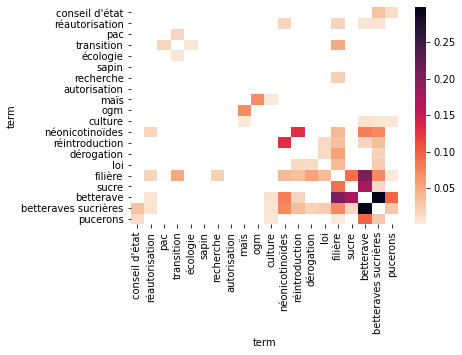

In [196]:
df11 = df1.loc[df1["in_top20_term"] ==  1]
df11["count_term"] = df11.groupby(['doc_id','term'])["in_top20_term"].transform('sum')
#df11["count_term2"] = df11.groupby(['term'])["doc_id"].transform('count')


t = pd.pivot_table(df11, index = "doc_id", columns = "term", values = "count_term", fill_value = 0)

corrMatrix = t.corr()


m = cluster_corr(corrMatrix)

mm = m.to_numpy()

for i in range(len(mm)):
    mm[i,i] = np.nan
    for j in range(len(mm)):
        if mm[i,j] <= 0:
            mm[i,j] = np.nan

cmap = sns.cm.rocket_r
sns.heatmap(m, cmap = cmap)
fig.set_size_inches(18.5, 10.5)

plt.savefig(f'segment{segment}_{domain}.png', bbox_inches='tight')

## Facebook

### 1√®re p√©riode : 16 novembre 2011 -- 31 janvier 2012:1√®re p√©riode (Segment 0)

<img src="segment0_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>



La premi√®re p√©riode sur facebook semble √™tre caract√©ris√©e par trois th√©matiques:

- La premi√®re concerne le proc√®s opposant Paul Fran√ßois (c√©r√©alier charantais) √† Monsanto. Paul Fran√ßois s'est retrouv√© dans le coma apr√®s avoir nettoy√© une cuve contenant du Lasso (produit commercialis√© par Monsanto). Le d√©bat a d√©but√© le 12 d√©cembre 2011.

> pesticides : un agriculteur en proc√®s contre monsanto Ce lundi 12 d√©cembre 2011, paul fran√ßois, agriculteur victime des pesticides, sera en proc√®s contre monsanto, en premi√®re instance, au TGI de Lyon, dans l'espoir de faire reconna√Ætre la faute de la firme et d'engager la responsabilit√© de cette derni√®re. bioaddict.fr Nous en appelons √† toutes celles et ceux qui le souhaitent √† se rendre au TGI de Lyon le 12 d√©cembre √† 13h30 pour t√©moigner de leur soutien √† paul fran√ßois et, ainsi, √† toutes les victimes des pesticides. [Auteur : BIO ADDICT]

- Un deuxi√®me ensemble de textes √©voque le probl√®me du d√©clin des pollinisateurs et, plus sp√©cifiquemet, des abeilles. Les "termes sp√©cifiques" du segment 0 que l'on retrouve dans ces textes sont par exemple : *'effet', 'pesticides', 'miel', 'parasite'*. **"Parasites"** et **"pesticides"** font r√©f√©rence √† deux des causes suppos√©es de disparition des abeilles (les pesticides √† travers les n√©onicotino√Ødes et les parasites avec le Varoa). Une disparition qui se manifesterait notamment par une baisse de production du **miel**.


> Fin des abeilles = fin du monde ? Oui bon, c‚Äôest peut-√™tre un peu exag√©r√©. Quoique‚Ä¶sans les abeilles, l‚Äô√©quilibre √©cologique serait gravement menac√©. En effet, les abeilles ont un r√¥le essentiel pour la survie des v√©g√©taux depuis 50 millions d‚Äôann√©es [...] On a d√©couvert que les abeilles sont toxico-sensibles et donc plus vuln√©rables que la plupart des autres insectes aux <mark>pesticides</mark>. [...] En France, le Gaucho de Bayer et le R√©gent de BASF, deux insecticides accus√©s de ravager les abeilles, ont √©t√© interdits en 2006 mais malgr√© tout l‚Äôh√©catombe se poursuit dans les ruches. On ne sait pas bien pourquoi et cela est tr√®s pr√©occupant. <mark>Certains apiculteurs soup√ßonnent que les pesticides</mark> toujours utilis√©s par l‚Äôagriculture sont √† l‚Äôorigine de ce qu‚Äôon appelle d√©sormais le ¬´ syndrome d‚Äôeffondrement des colonies ¬ª, maladie dont on ne sait pas encore grand-chose. [...] R√©cemment, <mark>d‚Äôautres explications</mark> ont √©t√© donn√©es quant √† la disparition des abeilles : 
> - <mark>Le frelon asiatique</mark> est montr√© du doigt. Cet insecte venu de l‚Äô√©tranger est un pr√©dateur f√©roce pour les abeilles puisqu‚Äôil se nourrit de leurs larves. 
> - <mark>Une mouche parasite</mark> est √©galement mise en cause depuis peu. Une √©tude am√©ricaine publi√©e en janvier 2012 a en effet mis en lumi√®re le r√¥le n√©faste de la mouche Apocephalus borealis. [Auteur: Let's save our Earth - Sauvons notre plan√®te]

- Un troisi√®me ensemble de textes porte sur le rapport publi√© par G√©n√©ration futures sur les  r√©sidus de pesticides dans l'alimentation

> Choisir de manger bio, c'est prot√©ger sa sant√© L'association g√©n√©rations futures a effectu√© des tests comparant un menu conventionnel et un menu bio : le r√©sultat est sans appel, le menu bio ne contenant quasiment aucun r√©sidus de pesticides. "Il y a 223 fois moins de r√©sidus de pesticides en moyenne dans les aliments bio analys√©s que dans les a... bioaddict.fr Mangez bio, c'est bon pour la sant√© ! Et √ßa, c'est vachement bien ! [Auteur : Les 2 vaches, industrie agroalimentaire]

- On trouve ensuite les textes qui prennent pour cible "Monsanto et son monde" ainsi que les effets sanitaires des produits commercialis√©s par la firme. Il s'agit probablement d'un ensemble de r√©actions √† la suite de la sortie du film √©ponyme *Le monde selon Monsanto*.

> *Le monde selon Monsanto* : Ce film retrace l'histoire de monsanto, une multinationale am√©ricaine, aujourd'hui leader mondial des ogm, et consid√©r√©e comme l'un des plus grands pollueurs de l'√®re industrielle (PCB, agent orange, hormones de croissance, roundup...). Apr√®s une enqu√™te de trois ans, en Am√©rique du nord et du sud, en europe et en Asie, il reconstitue la gen√®se d'un empire industriel, qui, √† grand renfort de rapports mensongers, de collusion avec l'administration nord-am√©ricaine, de pressions et tentatives de corruption, est devenu l'un des premiers semenciers de la plan√®te.

Il est int√©ressant de noter que Monsanto (et d'autres firmes comme Syngenta ou Bayer) semble √™tre le lien entre diff√©rents "cluster": l'affaire Paul Fran√ßois, les d√©bats li√©s au Roundup.

- Enfin, de nombreux posts √©voquent les "pesticides" de fa√ßon g√©n√©rale sans faire de lien √† une affaire en particulier.


### 2e p√©riode :  (Segment 1)

<img src="segment1_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 3√®me p√©riode : (Segment 2)

<img src="segment2_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 4√®me p√©riode : (Segment 3)

<img src="segment3_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 5√®me p√©riode : (Segment 4)

<img src="segment4_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 6√®me p√©riode : (Segment 5)

<img src="segment5_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 6√®me p√©riode : (Segment 5)

<img src="segment5_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 7√®me p√©riode : (Segment 6)

<img src="segment6_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 8√®me p√©riode : (Segment 7)

<img src="segment7_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 9√®me p√©riode : (Segment 8)

<img src="segment8_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 10√®me p√©riode : (Segment 9)

<img src="segment9_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 11√®me p√©riode : (Segment 10)

<img src="segment10_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 12√®me p√©riode : (Segment 11)

<img src="segment11_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 13√®me p√©riode : (Segment 12)

<img src="segment12_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

## Test (annexe)

In [ ]:
text = df2['text'].loc[(df2["doc_id"] == "413916")]
for x in text :
    print(x)

In [ ]:
text = """Sant√© Canada re√ßoit l'ordre de r√©examiner les effets environnementaux du Roundup | equiterre.org 
- P La Cour f√©d√©rale du Canada a ordonn√© √† Sant√© Canada de r√©√©valuer sa d√©cision de ne pas examiner les effets 
d'un herbicide, commercialis√© sous le nom de Roundup. Ce pesticide est un des plus populaires sur le march√© et 
il accompagne une proportion importante des plantes modifi√©es g√©n√©tiquement utilis... equiterre.org 
Sant√© Canada re√ßoit l'ordre de la Cour f√©d√©rale de r√©examiner les effets environnementaux du RoundUp!"""

In [ ]:
list_term = ["pesticides", "roundup"]

In [ ]:
import re
for j, term in enumerate(list_term):
    if term[-1]== "s":
        singular_term = term[0:-1]
    else:
        singular_term = term
    #text = text.replace(term[0:len(term)-1], f'<mark style="background-color:yellow">{term}</mark>')
    text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)          #

display(HTML(f'{text}'))